# Post-processing the PISN Line Analysis

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [25]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import corner
import h5py
from scipy.interpolate import interp1d, interp2d
import seaborn as sns
from true_params import true_params

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

Processing code to get us started.

For publication figures:

In [3]:
fs = 433.62/72.0
figsize_pub=(fs, fs)

This will efficiently find the shortest posterior interval in 1D that contains the given fraction of samples.

In [4]:
def spd_interval(samps, p):
    samps = sort(samps)
    N = samps.shape[0]
    Nint = int(round(p*N))
    Nout = N-Nint
    
    starts = samps[0:Nout]
    ends = samps[N-Nout:N]
    
    i = np.argmin(ends - starts)

    return starts[i], ends[i]

This function will produce nicely formatted intervals like $X = x^{+dx}_{-dx'}$ with at least two digits in each upward and downward interval.

In [5]:
def interval_string(d, prefix='', postfix='', f=0.68):
    s = d
    m = median(s)
    l, h = spd_interval(s, f)
    
    dl = m-l
    dh = h-m
    
    il = 10**(int(np.ceil(log10(dl))) - 2)
    ih = 10**(int(np.ceil(log10(dl))) - 2)
    
    i = min(il, ih)
    
    m = i*int(round(m/i))
    dl = i*int(round(dl/i))
    dh = i*int(round(dh/i))
    
    return prefix + '{:g}^{{+{:g}}}_{{-{:g}}}'.format(m, dh, dl) + postfix

Some cosmology:

In [23]:
def Hz(z, H0, Om, w):
    return H0*np.sqrt(Om*(1+z)**3 + (1.0-Om)*(1+z)**(3*(1+w)))

Plotting codes:

In [6]:
def load_chains(f, selector=None):
    names = ['H0', 'Om', 'w', 'R0', 'MMin', 'MMax', 'alpha', 'beta', 'gamma', 'sigma_low', 'sigma_high', 'Nex', 'neff_det']
    
    if selector is None:
        selector = slice(None)
    
    c = {}
    with h5py.File(f, 'r') as inp:
        for n in names:
            c[n] = array(inp[n])[selector, ...]
    return c

In [7]:
def traceplot(c):
    nr = 8
    nc = 1
    
    names = ['H0', 'Om', 'w', 'R0', 'MMin', 'MMax', 'alpha', 'beta', 'gamma', 'sigma_low', 'sigma_high']
    
    for i in range(nr):
        subplot(nr, nc, i+1)
        
        x = c[names[i]]
        
        if len(x.shape) == 1:
            plot(x)
        elif len(x.shape) == 2:
            for j in range(x.shape[1]):
                plot(x[:,j])
        else:
            raise NotImplementedError('Cannot plot matrices or higher-dimensional tensors')
        
        ylabel(names[i])
    tight_layout()

In [8]:
def Neff_plot(c, *args, **kwargs):
    sns.distplot(c['neff_det'], *args, **kwargs)
    
    ndet = np.mean(c['Nex'])
    
    axvline(ndet, color='k')
    
    xlabel(r'$N_\mathrm{eff}$')
    ylabel(r'$p\left( N_\mathrm{eff} \right)$')

In [11]:
def cosmo_corner_plot(c, *args, **kwargs):
    corner.corner(column_stack([c[n] for n in ['H0', 'Om', 'w']]),
              labels=[r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}$)', 
                      r'$\Omega_M$',
                      r'$w$'],
              truths=[Planck15.H0.to(u.km/u.s/u.Mpc).value, 
                      Planck15.Om0,
                      -1],
              truth_color=sns.color_palette()[0],
              quantiles=[0.16, 0.84],
              show_titles=True)

In [30]:
def pop_corner_plot(c, *args, **kwargs):
    corner.corner(column_stack([c[n] for n in ['R0', 'MMin', 'MMax', 'alpha', 'beta', 'gamma']]),
              labels=[r'$R_0$ ($\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}$)',
                      r'$M_\mathrm{min}$ ($M_\odot$)',
                      r'$M_\mathrm{max}$ ($M_\odot$)',
                      r'$\alpha$',
                      r'$\beta$',
                      r'$\gamma$'],
              truths=[true_params['R0'],
                      true_params['MMin'],
                      true_params['MMax'],
                      true_params['alpha'],
                      true_params['beta'],
                      true_params['gamma']],
              truth_color=sns.color_palette()[0],
              quantiles=[0.16, 0.84],
              show_titles=True)

In [13]:
def H0_plot(c, *args, **kwargs):
    sns.kdeplot(c['H0'], *args, **kwargs)
    xlabel(r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$)')
    ylabel(r'$p\left( H_0 \mid d \right)$')
    axvline(Planck15.H0.to(u.km/u.s/u.Mpc).value, color='k')

    m = median(c['H0'])
    l, h = spd_interval(c['H0'], 0.68)
    ll, hh = spd_interval(c['H0'], 0.95)

    axvline(m)
    axvline(l, ls='--')
    axvline(h, ls='--')
    axvline(ll, ls=':')
    axvline(hh, ls=':')

In [14]:
def w_plot(c, *args, **kwargs):
    sns.kdeplot(c['w'], *args, **kwargs)
    xlabel(r'$w$')
    ylabel(r'$p\left( w \right)$')
    axvline(-1, color='k')

    m = median(c['w'])
    l, h = spd_interval(c['w'], 0.68)
    ll, hh = spd_interval(c['w'], 0.95)

    axvline(m)
    axvline(l, ls='--')
    axvline(h, ls='--')
    axvline(ll, ls=':')
    axvline(hh, ls=':')

In [28]:
def MMax_plot(c, *args, **kwargs):
    sns.kdeplot(c['MMax'], *args, **kwargs)
    xlabel(r'$M_\mathrm{max}$ ($M_\odot$)')
    ylabel(r'$p\left( M_\mathrm{max} \right)$')
    axvline(true_params['MMax'], color='k')

    m = median(c['MMax'])
    l, h = spd_interval(c['MMax'], 0.68)
    ll, hh = spd_interval(c['MMax'], 0.95)

    axvline(m)
    axvline(l, ls='--')
    axvline(h, ls='--')
    axvline(ll, ls=':')
    axvline(hh, ls=':')

In [20]:
def Hz_plot(c, *args, **kwargs):
    zs = linspace(0, 2, 1000)
    
    plot(zs, Hz(zs, Planck15.H0.to(u.km/u.s/u.Mpc).value, Planck15.Om0, -1), '-k')
    
    Hs = Hz(zs[newaxis,:], c['H0'][:,newaxis], c['Om'][:,newaxis], c['w'][:,newaxis])
    
    m = median(Hs, axis=0)
    l = percentile(Hs, 16, axis=0)
    ll = percentile(Hs, 2.5, axis=0)
    h = percentile(Hs, 84, axis=0)
    hh = percentile(Hs, 97.5, axis=0)
    
    plot(zs, m, color=sns.color_palette()[0])
    fill_between(zs, h, l, color=sns.color_palette()[0], alpha=0.25)
    fill_between(zs, hh, ll, color=sns.color_palette()[0], alpha=0.25)
    
    xlabel(r'$z$')
    ylabel(r'$H(z)$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$)')
    
    print('Redshift at which 1-sigma H(z) interval min is {:.2f}'.format(zs[argmin((h-l)/m)]))

In [21]:
def post_process(f, selector=None):
    c = load_chains(f, selector=selector)
    
    traceplot(c)
    
    figure()    
    Neff_plot(c)
    
    figure()
    Hz_plot(c)
    
    cosmo_corner_plot(c)
    pop_corner_plot(c)
    
    figure()
    H0_plot(c)
    title(interval_string(c['H0'], prefix=r'$H_0 = ', postfix=r' \, \mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$'))
    
    figure()
    w_plot(c)
    title(interval_string(c['w'], prefix=r'$w = ', postfix='$'))
    
    figure()
    MMax_plot(c)
    title(interval_string(c['MMax'], prefix=r'$M_\mathrm{max} = ', postfix=' \, M_\odot$'))
    
    return c

## Small (1 Month) Runs

/Users/wfarr/anaconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '


Redshift at which 1-sigma H(z) interval min is 0.03


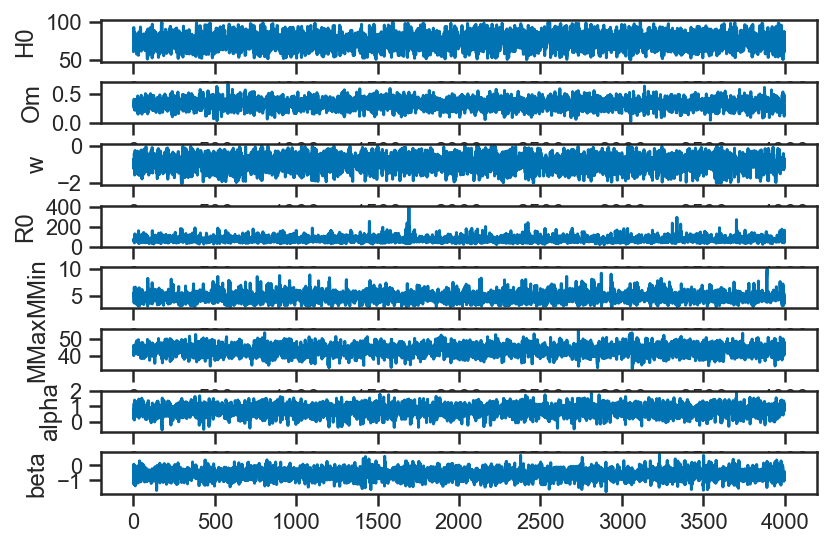

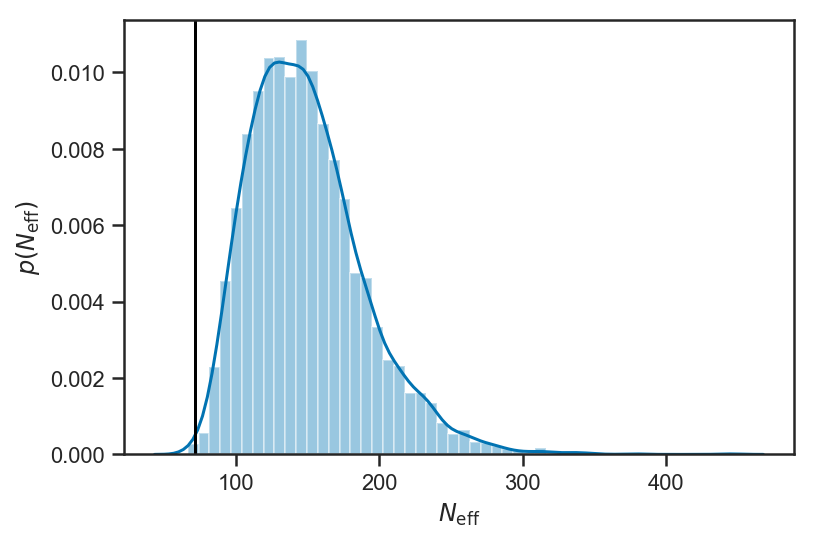

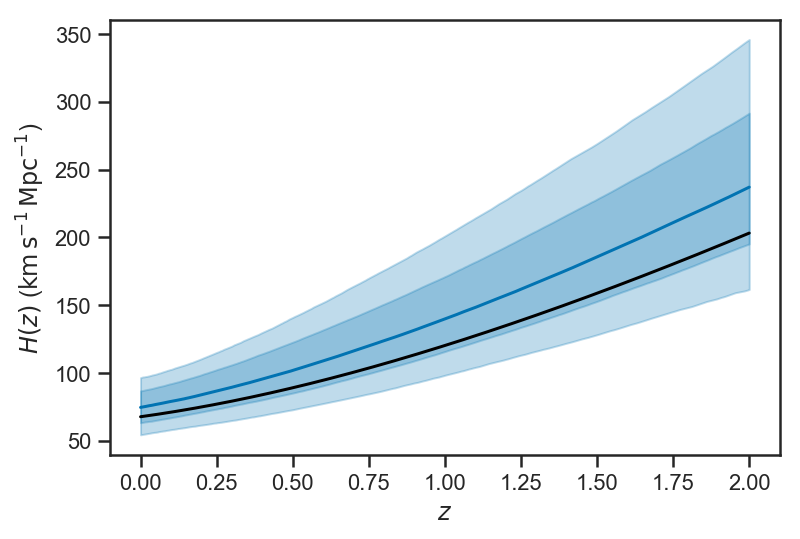

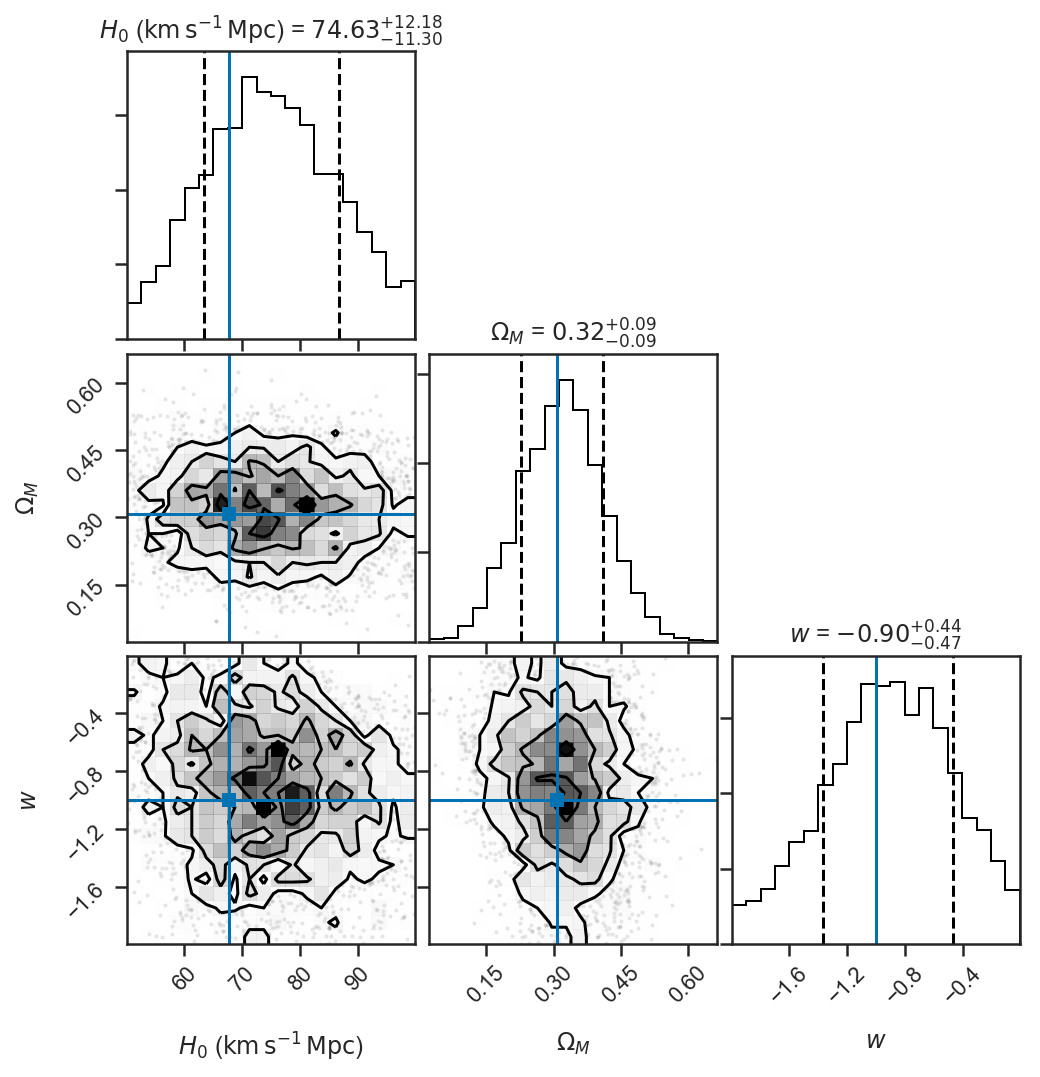

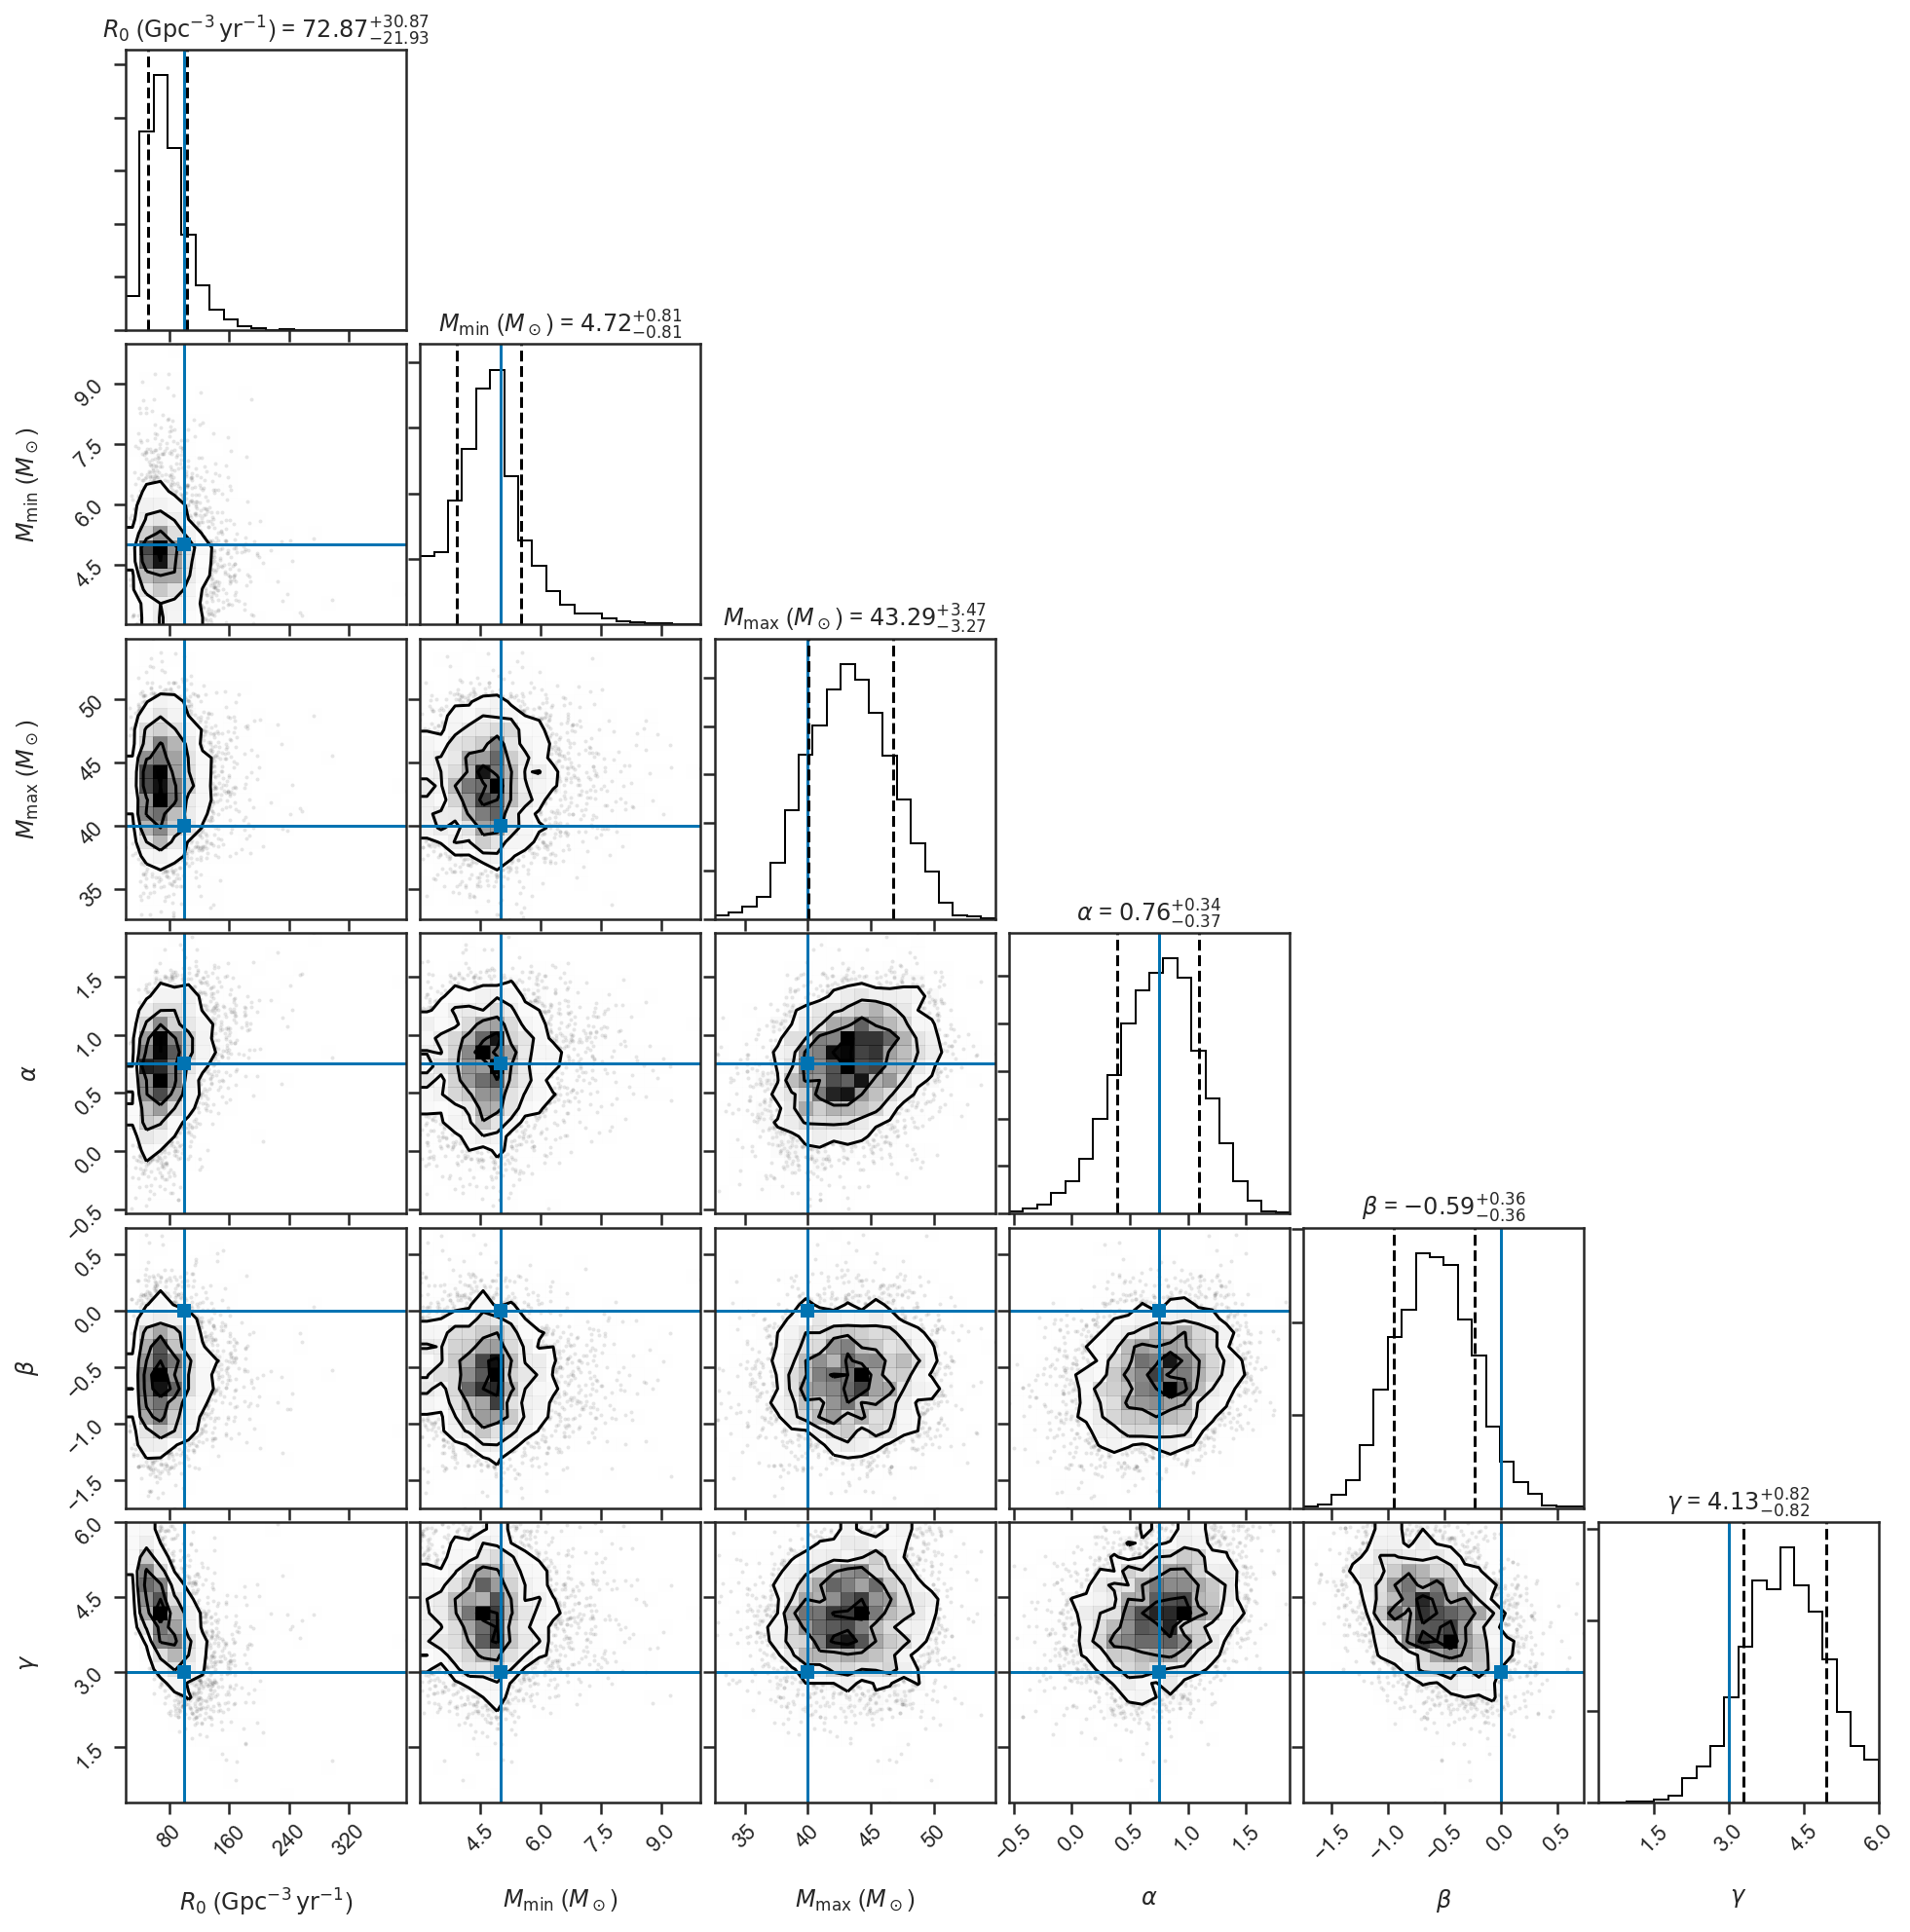

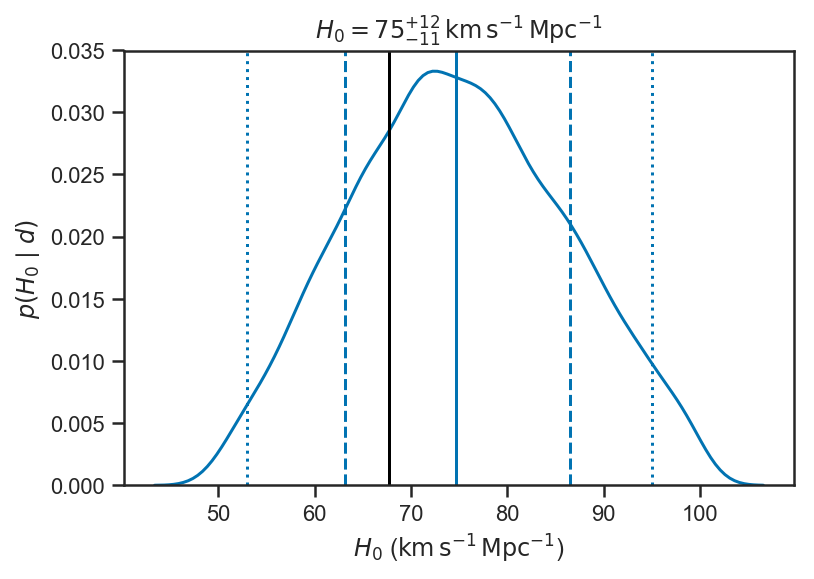

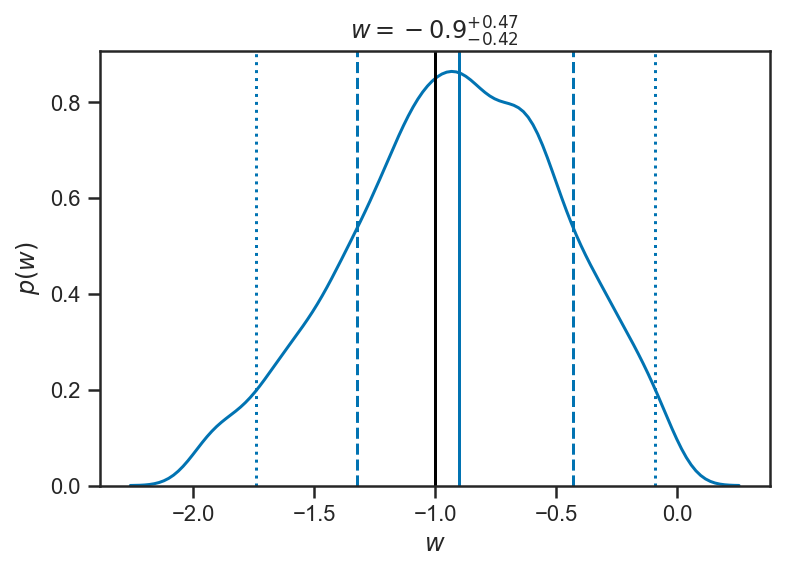

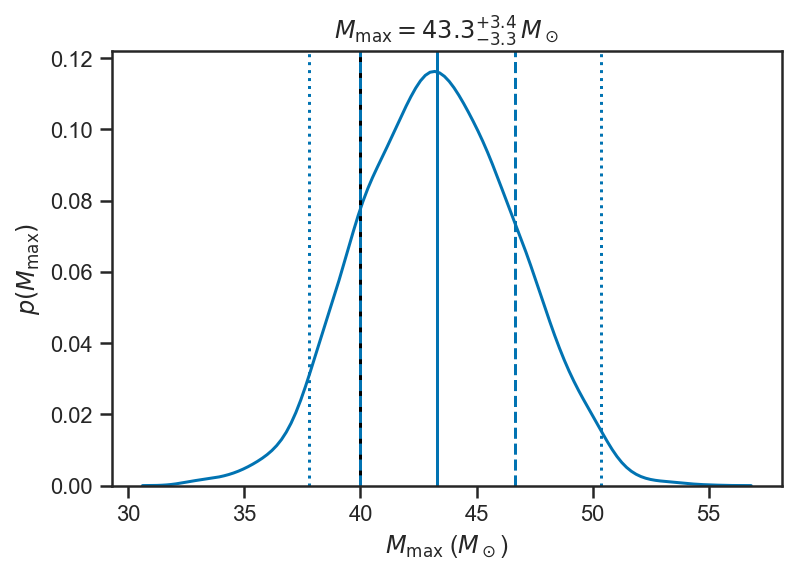

In [31]:
c_small = post_process('population_small.h5')

/Users/wfarr/anaconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '
/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Redshift at which 1-sigma H(z) interval min is 0.00


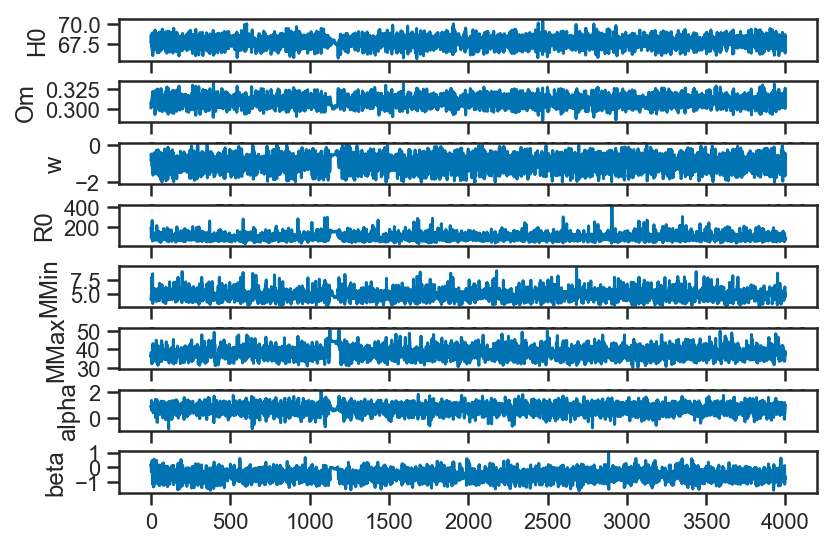

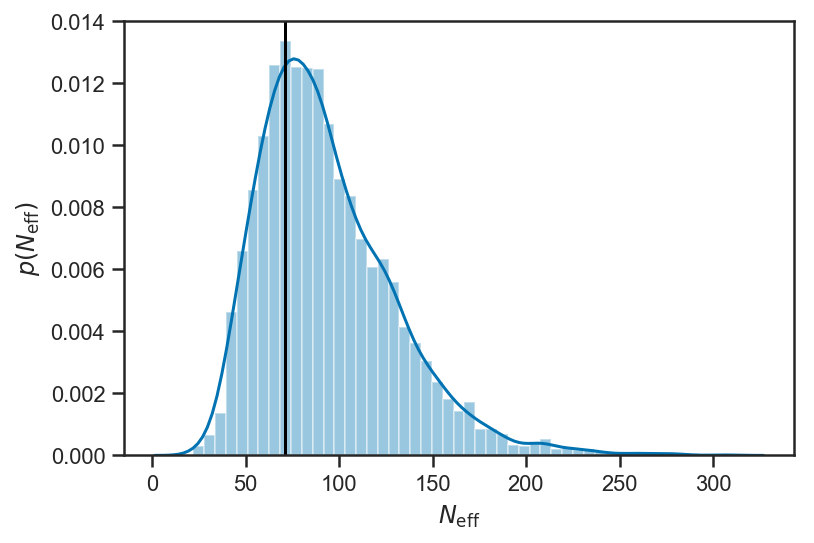

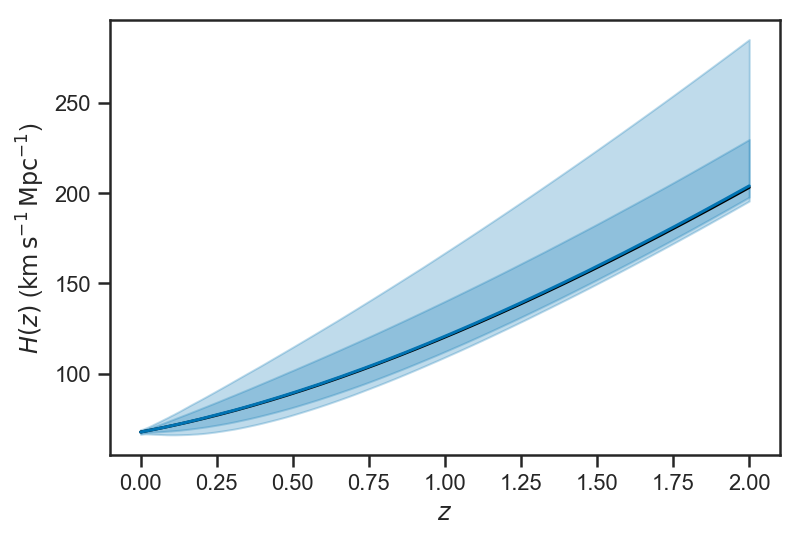

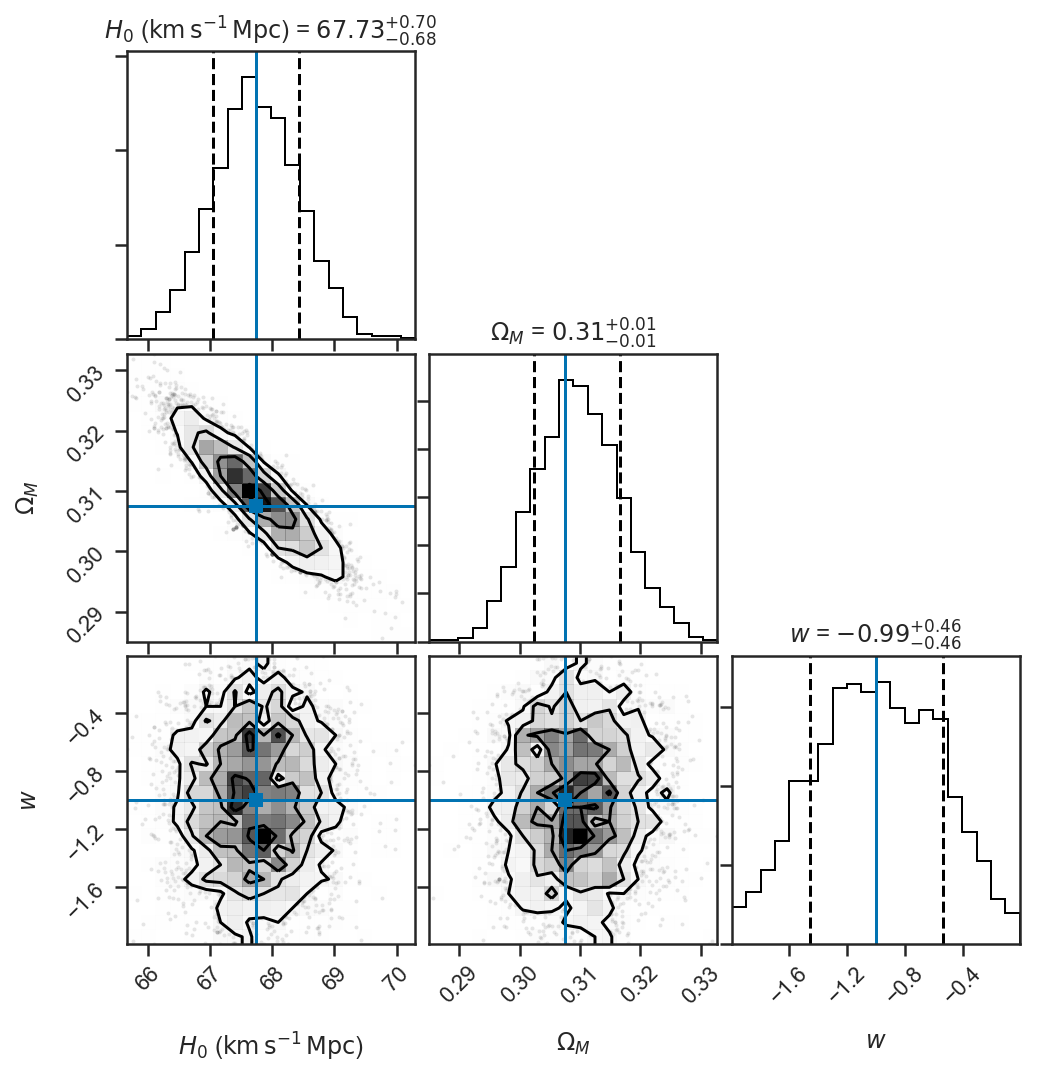

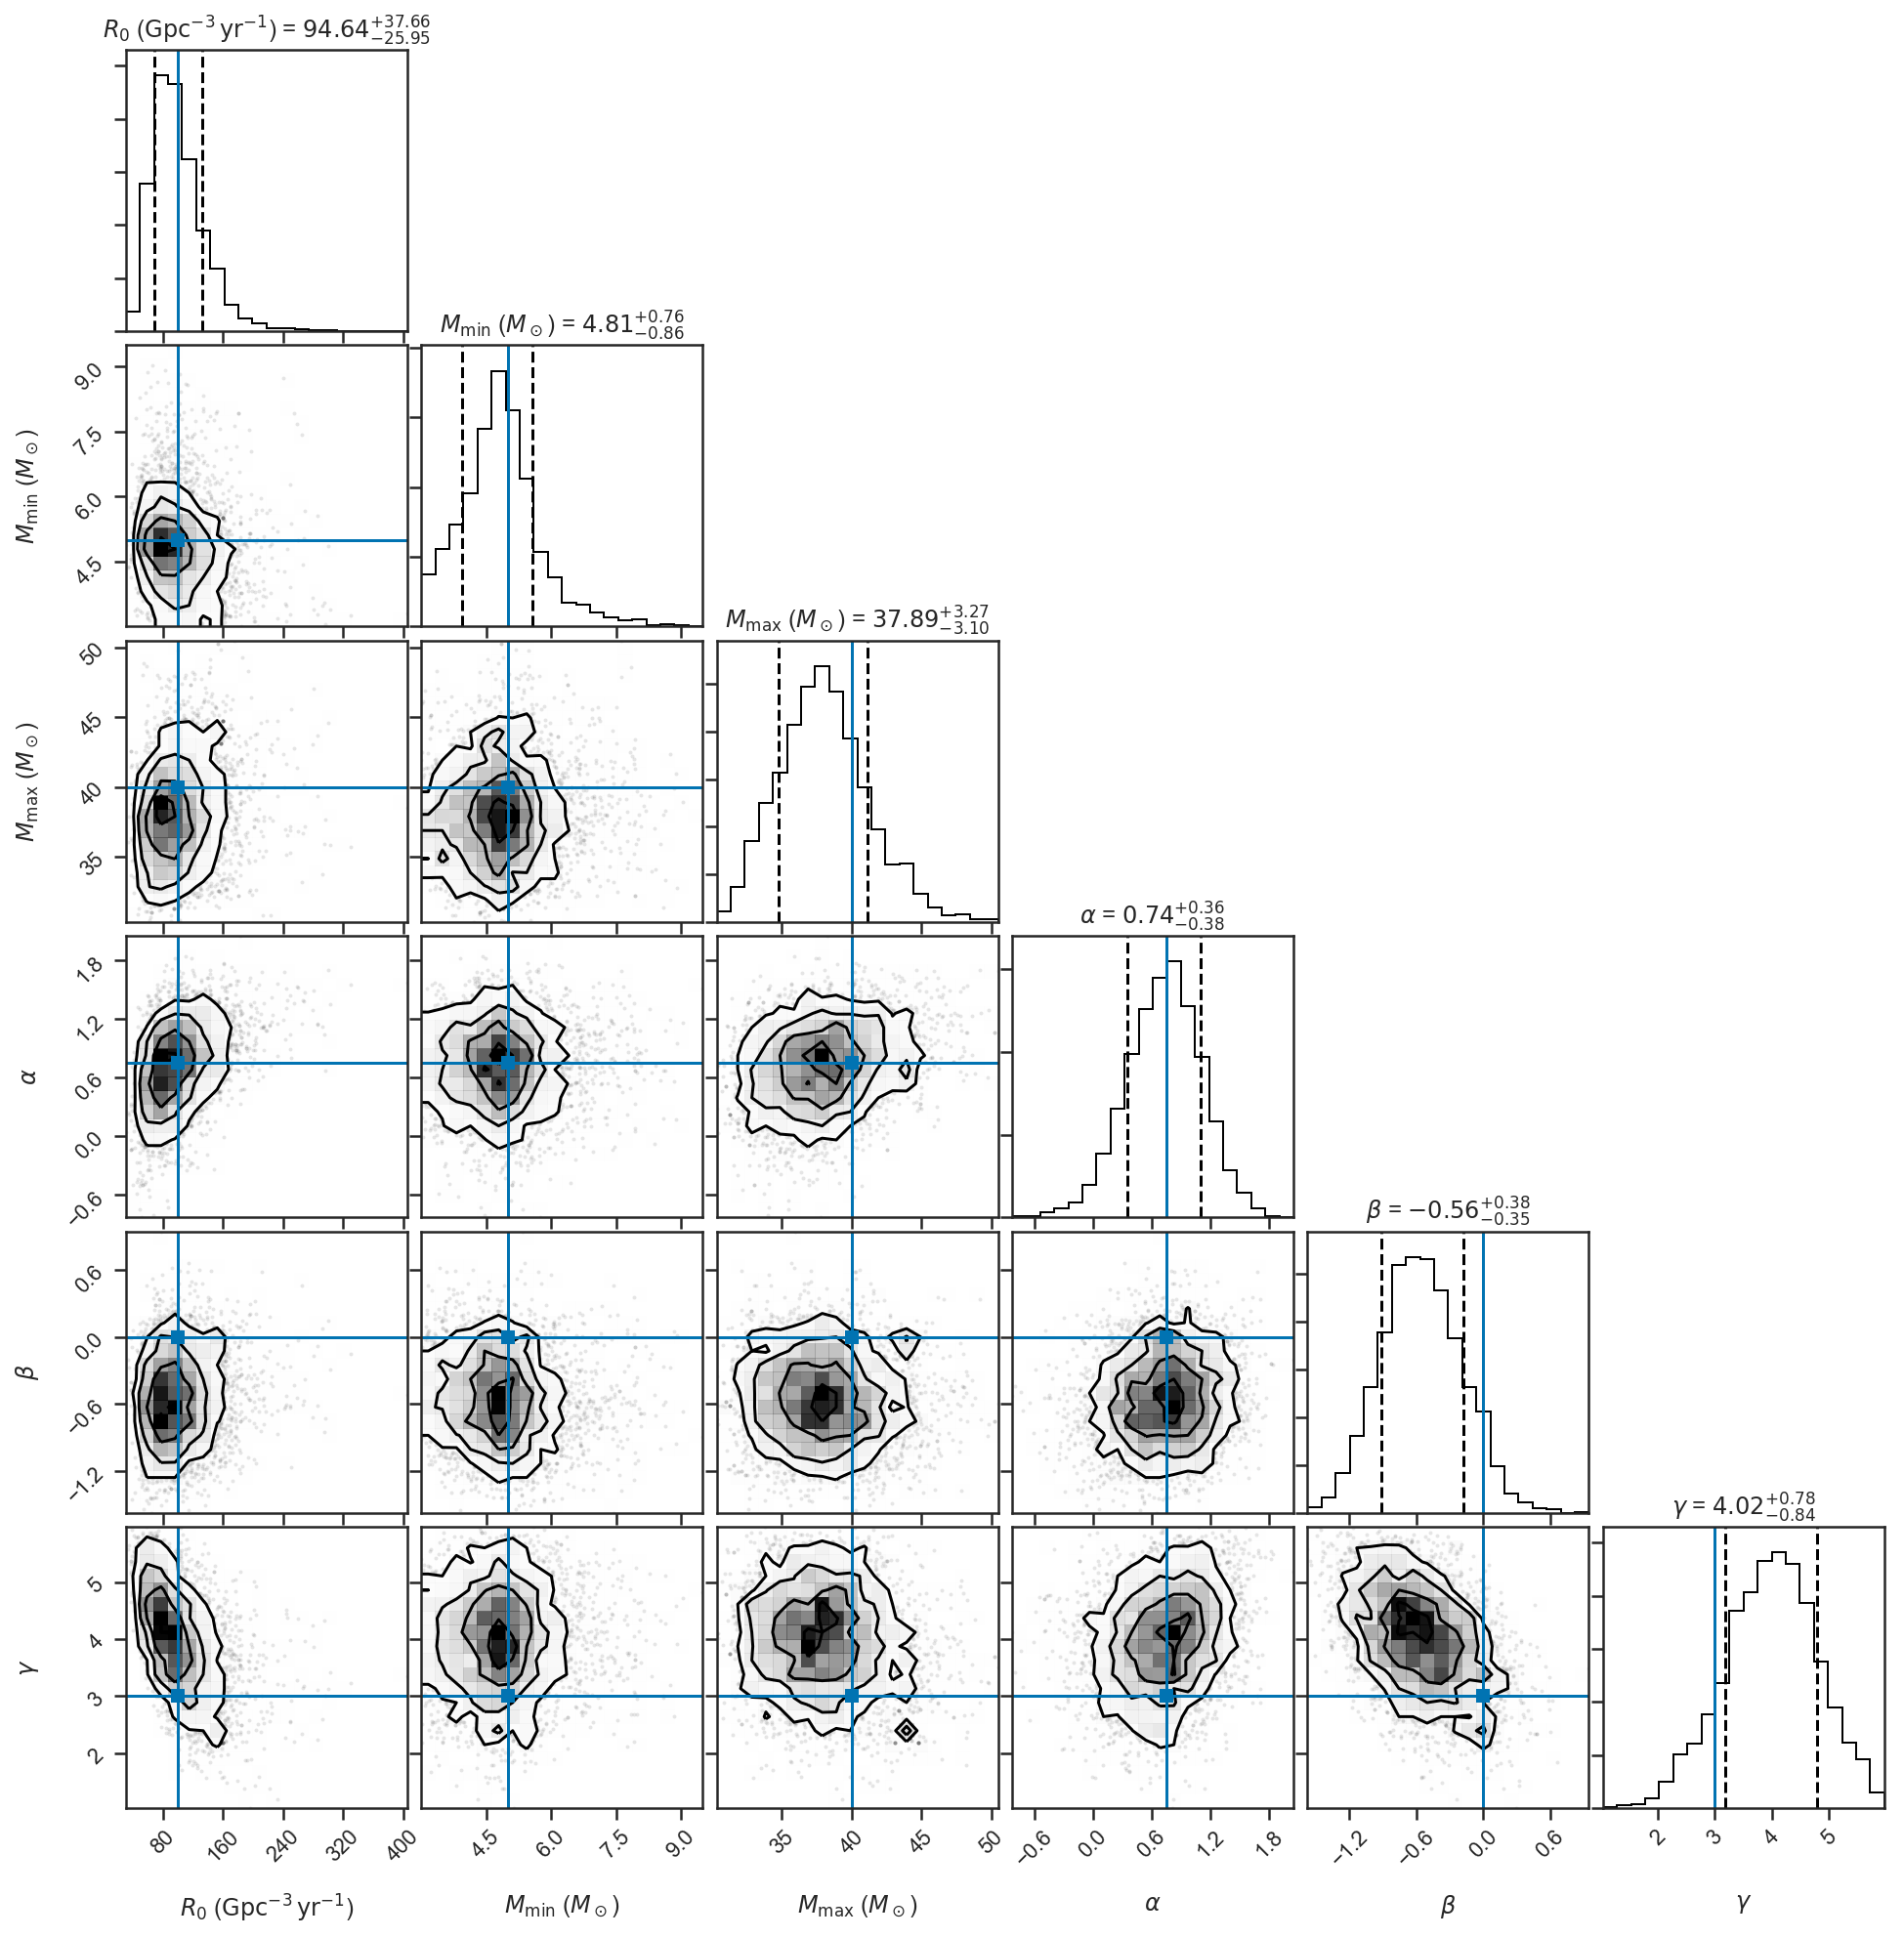

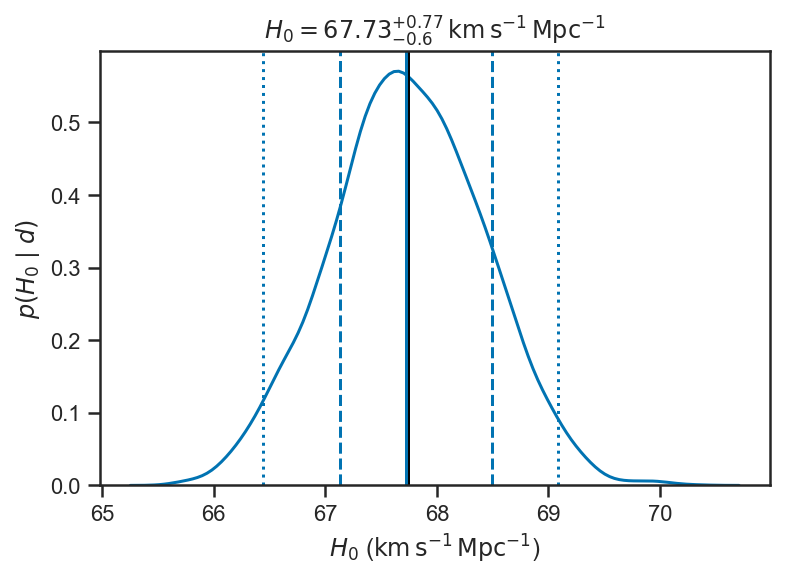

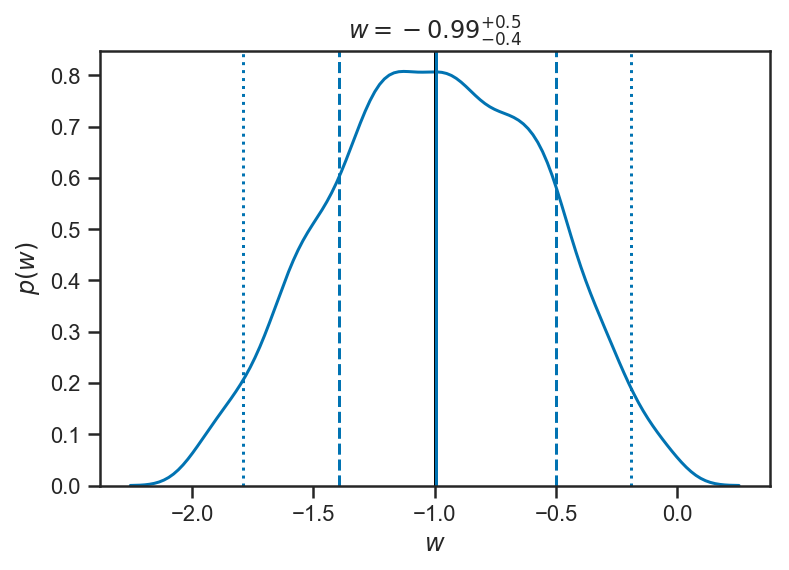

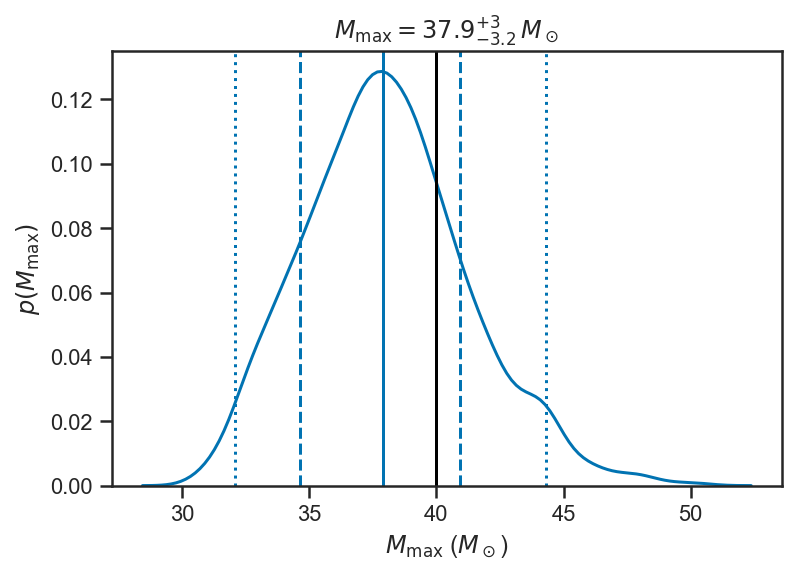

In [32]:
c_small_cosmo = post_process('population_small_cosmo.h5')